In [1]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 
import shlex
import os
import pickle 
from get_model_parameters import separate_parts, graph_with_attributes 
from family_model_intergenerational_marriage import get_graph_stats
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
source_dir = 'Original_Sources'
name = 'arara'

marriage_dist, num_marriages, prob_inf_marriage, prob_finite_marriage, child_dist, size_goal = get_graph_stats(name)
path_to_paj = source_dir+'\kinsources-'+name+'-oregraph.paj'
vertex_names, marriage_edges, child_edges = separate_parts(path_to_paj,'A')

In [3]:
G = graph_with_attributes(path_to_paj, directed=True)
ancestral_trees = []  # tuples of ancestral trees, ordered as in finite_marriages 
# find the subtrees of ancestors for each finite-distance-couple in the named graph
mask = np.array(marriage_dist) != -1 
finite_marriages = np.array(marriage_edges)[mask]
finite_marriage_distances = np.array(marriage_dist)[mask] 
for dist, couple in zip(finite_marriage_distances, finite_marriages):
    # get parents
    paternal_gen = {couple[0]}
    maternal_gen = {couple[1]}
    paternal_tree = paternal_gen.copy()
    maternal_tree = maternal_gen.copy()
    intersection = paternal_tree.intersection(maternal_tree)
    dist = 0
    paternal_distances = {couple[0]:dist}
    maternal_distances = {couple[1]:dist}
    while len(intersection) == 0:

        dist += 1
        paternal_gen = set([parent[0] for ancestor in paternal_gen for parent in G.in_edges(ancestor)])
        maternal_gen = set([parent[0] for ancestor in maternal_gen for parent in G.in_edges(ancestor)])
        paternal_distances = paternal_distances | {ancestor: dist for ancestor in paternal_gen if ancestor not in paternal_distances}  # if clause prevents overwriting distances if we encounter the same ancestor at multiple distances 
        maternal_distances = maternal_distances | {ancestor: dist for ancestor in maternal_gen if ancestor not in maternal_distances}
        paternal_tree = paternal_tree.union(paternal_gen)
        maternal_tree = maternal_tree.union(maternal_gen)
        intersection = paternal_tree.intersection(maternal_tree)
        #     if len(paternal_gen) == 0 and len(maternal_gen) == 0 and len(intersection) == 0:
        #         # IE if both trees are exhausted, no new parents
        #         dist = -1  # IE infinite distance marraige
        #         break
        # if dist == -1:
        #     distances.append(dist)
        # else:
        # min_dist = min([paternal_distances[common_ancestor] + maternal_distances[common_ancestor] for common_ancestor in intersection])
        # distances.append(min_dist)
    g1 = G.subgraph(paternal_tree)
    g2 = G.subgraph(maternal_tree)
    ancestral_trees.append((g1, g2, paternal_distances, maternal_distances))


In [4]:
parent_child_width = 1
parent_child_alpha= 1
highlight_alpha = 0.65
node_size = 10
#%%
idx = 37 # 13 was also good, had multiple distances 
couple = finite_marriages[idx]
g1, g2, paternal_distances, maternal_distances = ancestral_trees[idx]
g = nx.compose(g1, g2)

In [5]:
figsize=(5, 10)
dpi=300
colors = ['lightsalmon', 'yellowgreen']
# common_colors = ['aquamarine', 'darkcyan']
common_colors = ['yellow', 'lime']
layout = graphviz_layout
layout_args = ['dot']
pos = layout(g, *layout_args)
pc_edges = g.edges() 
common = [node for node in g1.nodes if node in g2.nodes]
not_couple_not_common = [node for node in g.nodes if node not in common and node not in couple]

C:\Users\kolto\AppData\Local\Temp\ipykernel_21768\2504958397.py:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = layout(g, *layout_args)


{3: Text(27.0, 234.0, '3'),
 4: Text(99.0, 234.0, '4'),
 5: Text(315.0, 234.0, '5'),
 38: Text(171.0, 90.0, '38'),
 7: Text(171.0, 234.0, '7'),
 105: Text(243.0, 306.0, '105'),
 13: Text(27.0, 162.0, '13'),
 14: Text(99.0, 162.0, '14'),
 82: Text(135.0, 18.0, '82'),
 18: Text(171.0, 162.0, '18'),
 60: Text(99.0, 90.0, '60'),
 100: Text(308.0, 18.0, '100'),
 6: Text(243.0, 234.0, '6'),
 8: Text(531.0, 234.0, '8'),
 43: Text(374.0, 162.0, '43'),
 11: Text(459.0, 234.0, '11'),
 15: Text(387.0, 234.0, '15'),
 20: Text(243.0, 162.0, '20'),
 57: Text(374.0, 90.0, '57'),
 31: Text(459.0, 162.0, '31')}

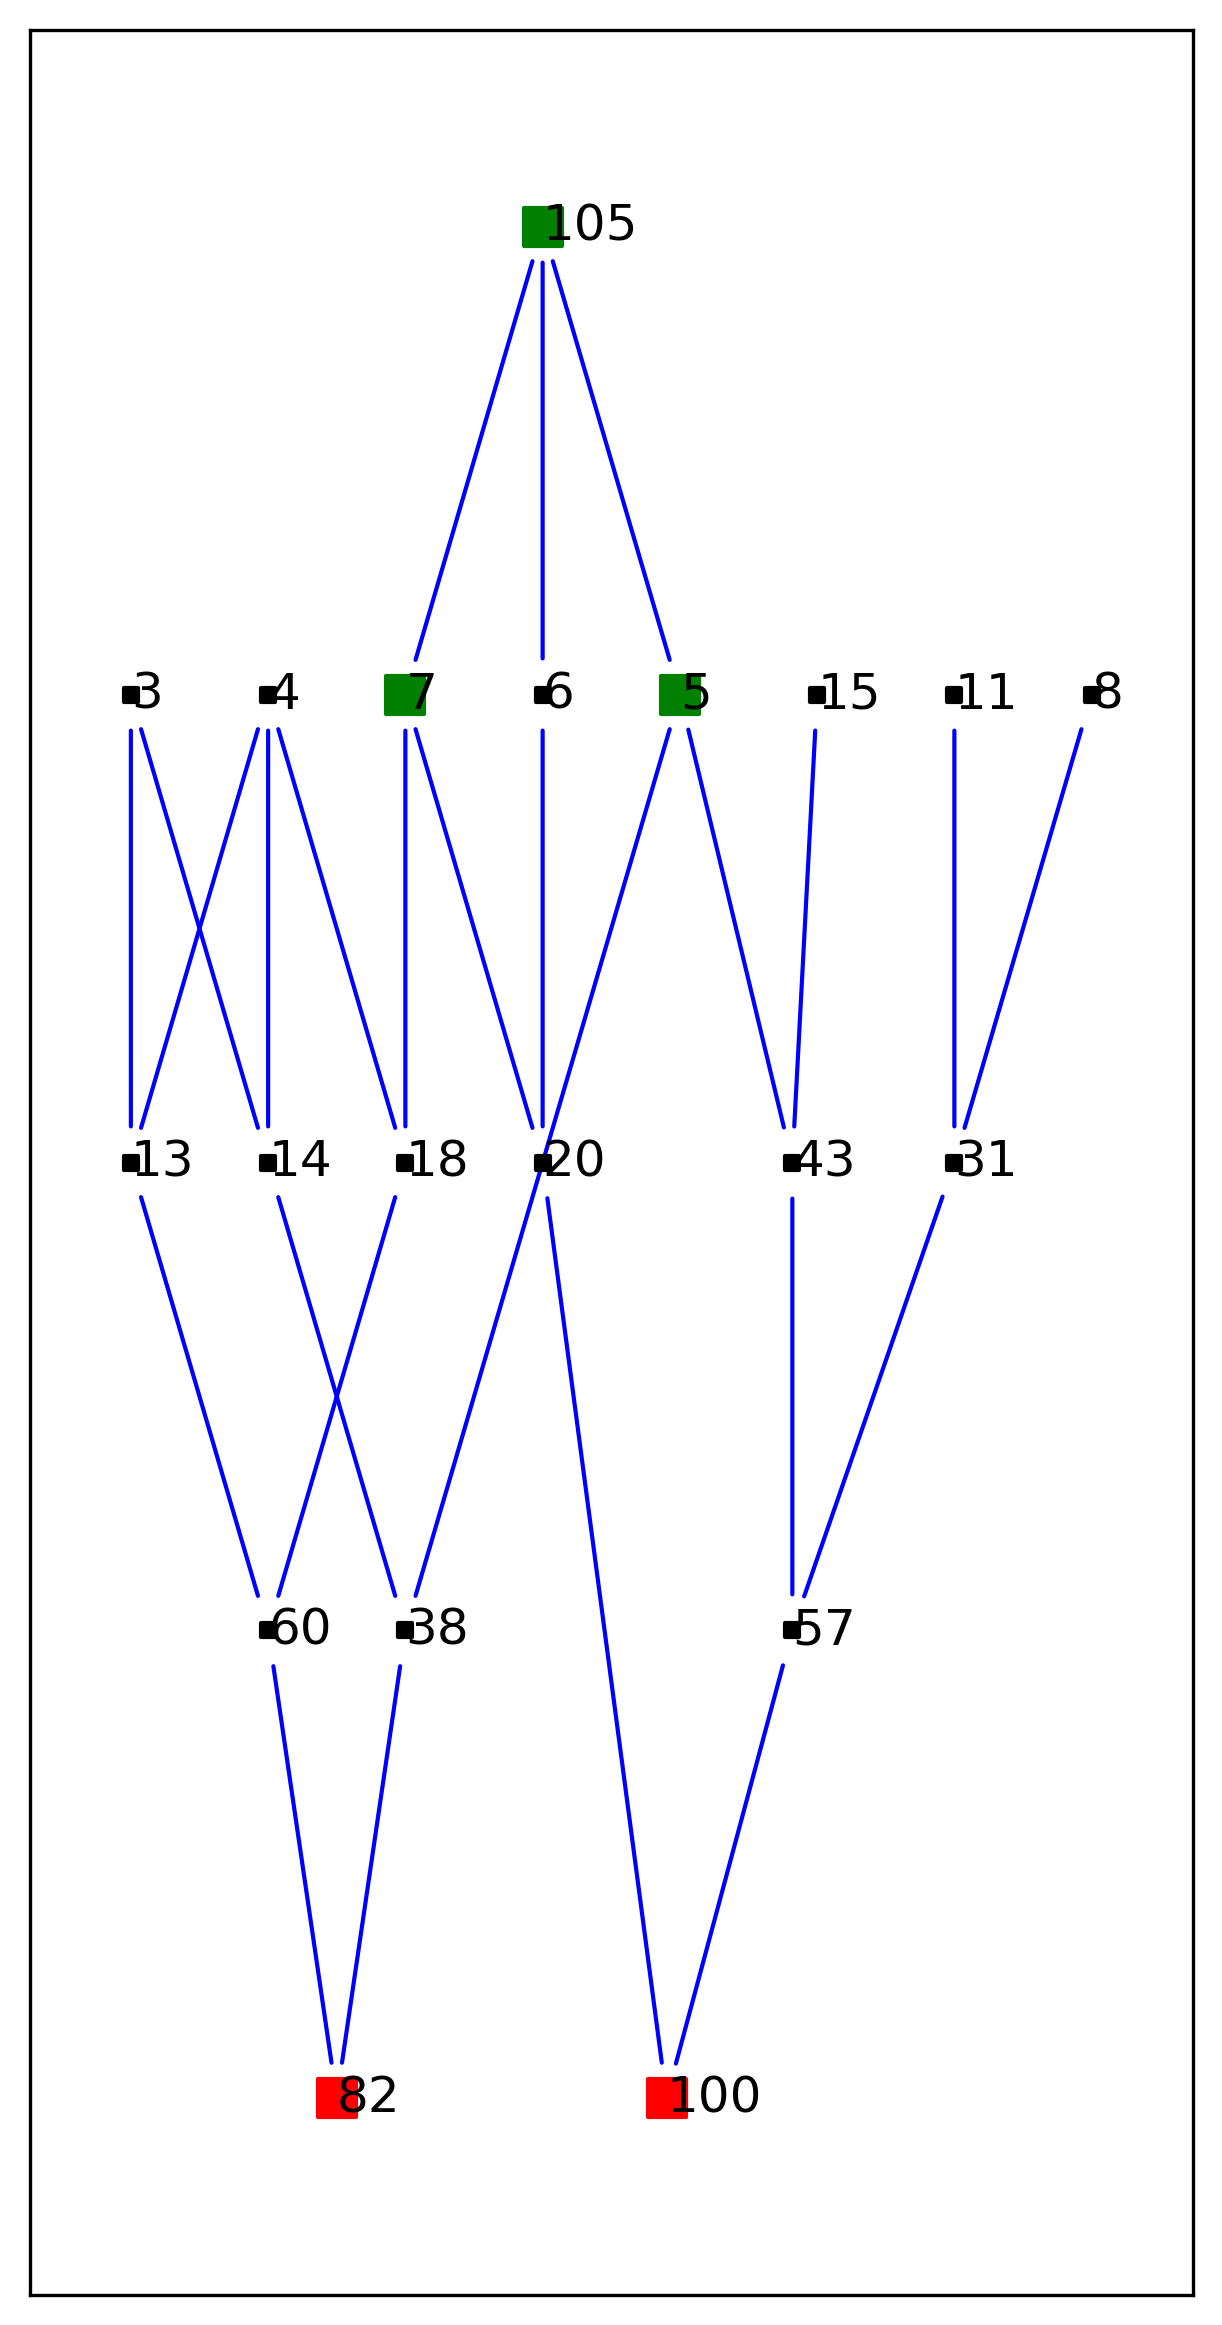

In [6]:


#%%
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=dpi)
# ax = plt.subplots(4, 1, 1)
nx.draw_networkx_edges(g, pos, pc_edges, ax=ax, edge_color='b',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
nx.draw_networkx_nodes(g, pos, not_couple_not_common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, common, ax=ax, node_shape='s', node_color='g', node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, couple, ax=ax, node_shape='s', node_color='r', node_size=node_size+70)
nx.draw_networkx_labels(g, pos, horizontalalignment='left')

In [7]:
pos[20] = (300., 162.)
# drop node 105, not needed for explanation 
g.remove_node(105)
# unfreeze to allow for modification 
g1 = nx.Graph(g1)
g2 = nx.Graph(g2)
g1.remove_node(105)
g2.remove_node(105)
pos.pop(105)
paternal_distances.pop(105)
maternal_distances.pop(105)
common = [node for node in g1.nodes if node in g2.nodes]

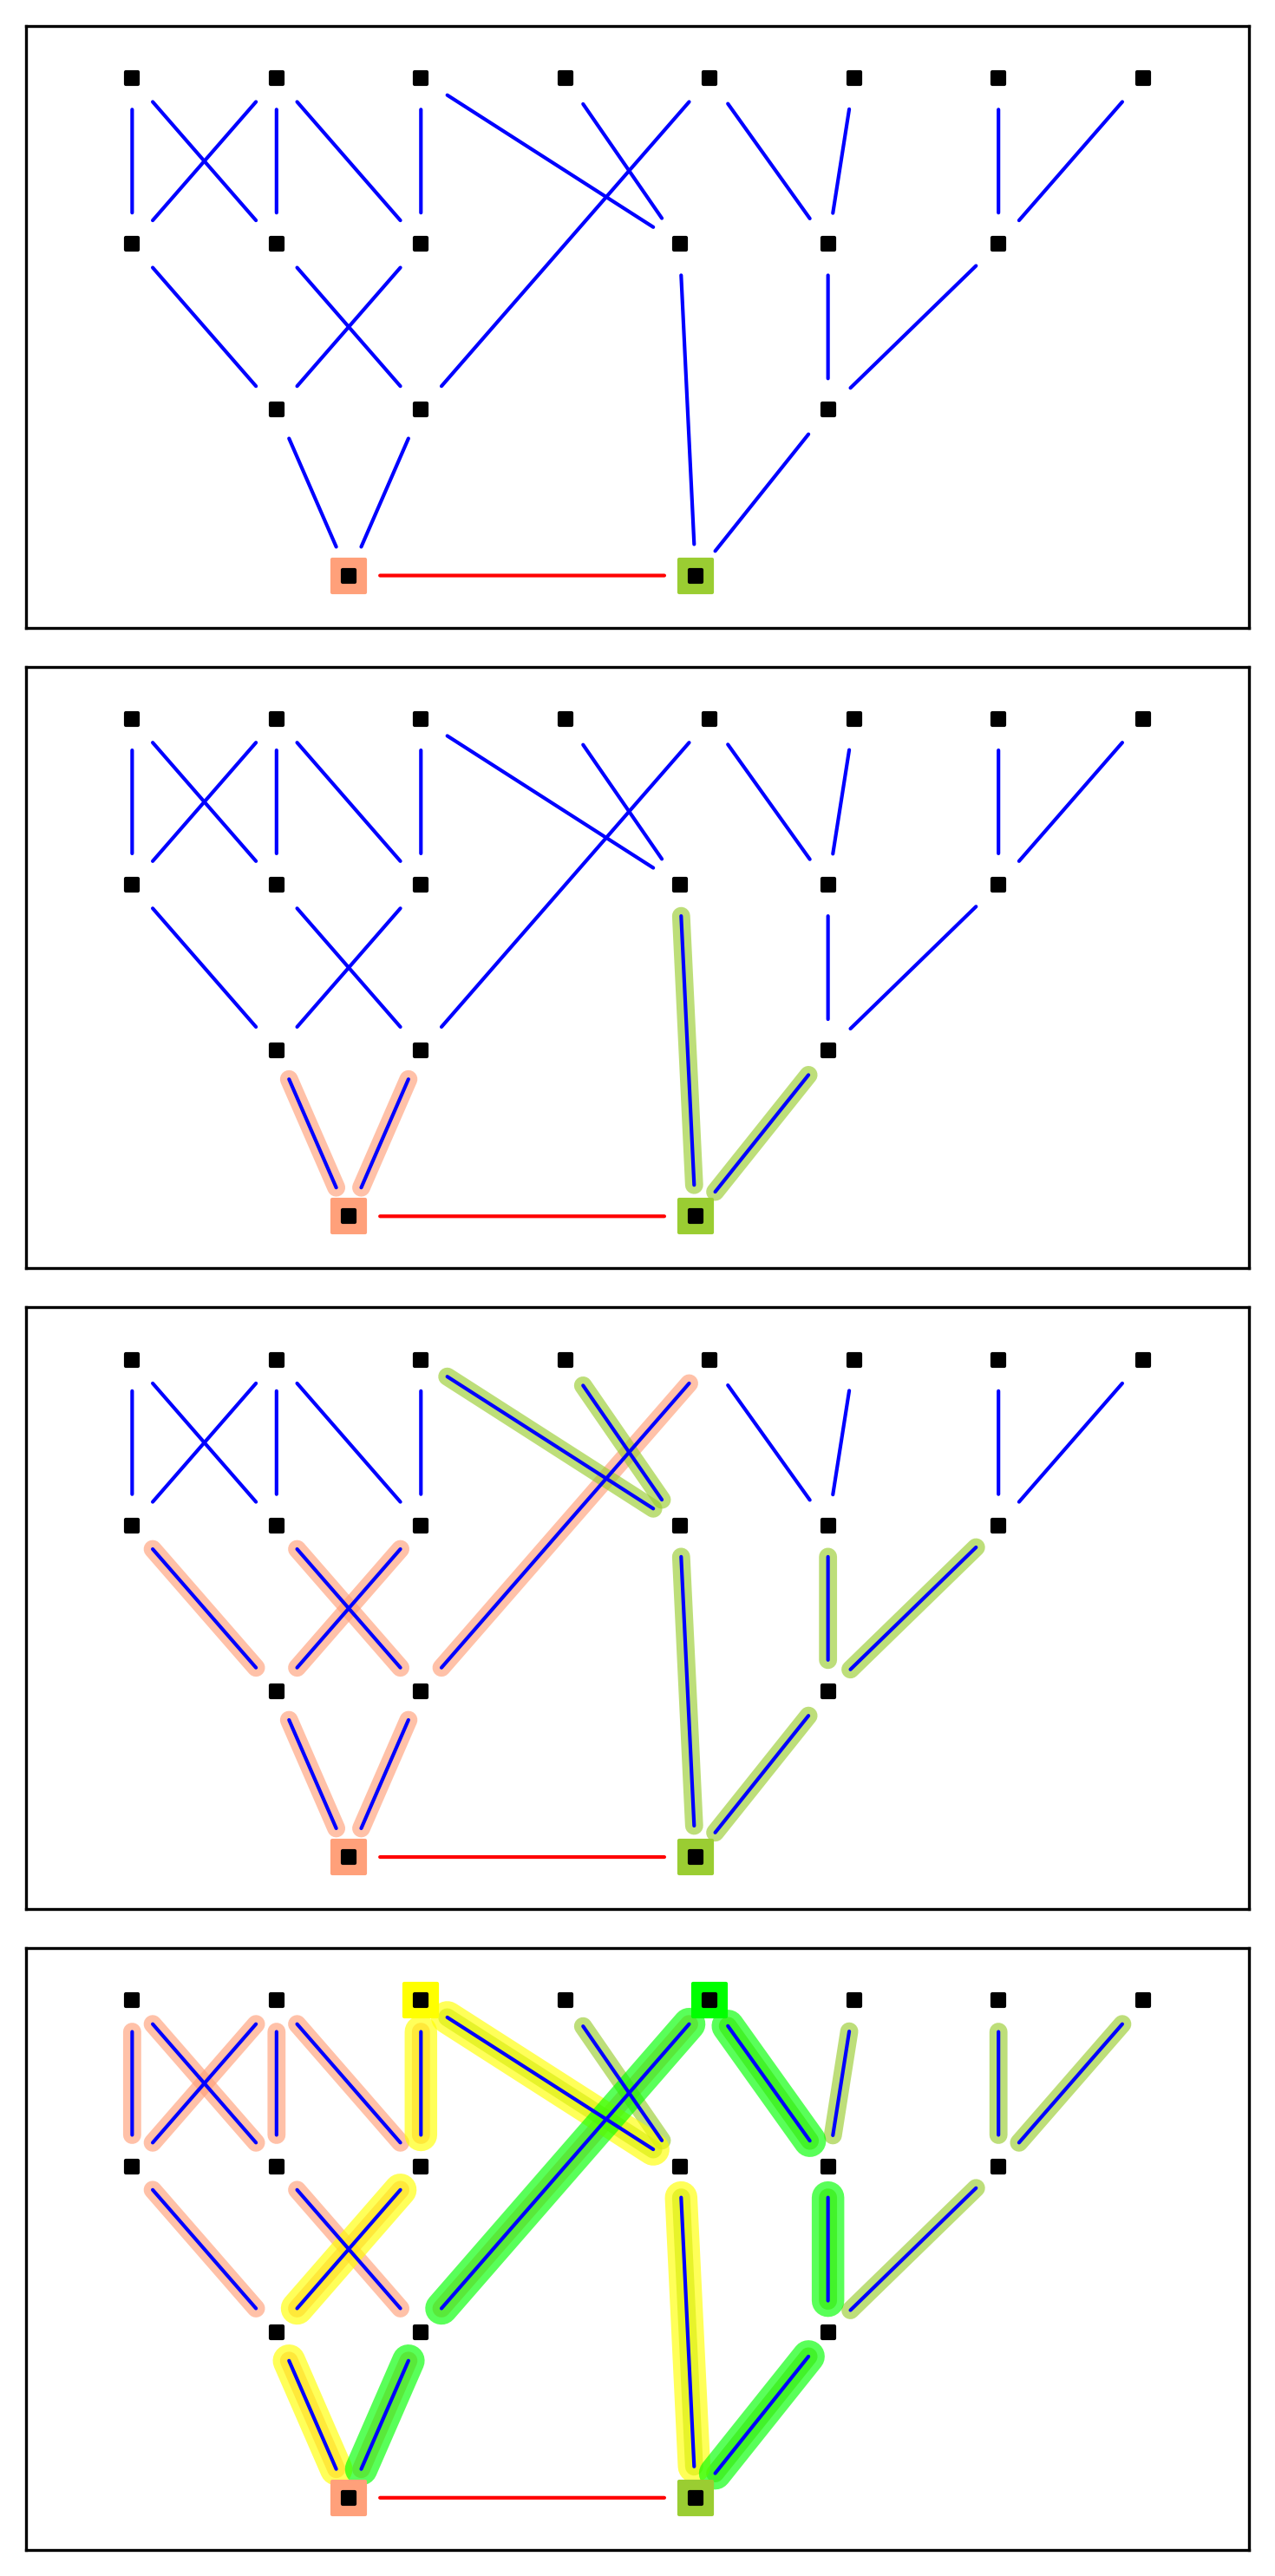

In [16]:
fig, ax = plt.subplots(4,1,figsize=figsize, dpi=dpi)
ax = plt.subplot(4, 1, 1)
nx.draw_networkx_edges(g, pos, pc_edges, ax=ax, edge_color='b',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
g.add_edge(*couple, Relationship='Marriage')
nx.draw_networkx_edges(g, pos, [(couple[0], couple[1])], ax=ax, edge_color='red',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
g.remove_edge(*couple)
nx.draw_networkx_nodes(g, pos, not_couple_not_common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color=colors[0], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color=colors[1], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
# nx.draw_networkx_labels(g, pos, horizontalalignment='left')

ax = plt.subplot(4,1,2)
nx.draw_networkx_edges(g, pos, g.in_edges([key for key in paternal_distances if paternal_distances[key] < 1]), ax=ax, edge_color=colors[0], width=parent_child_width+4, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_edges(g, pos, g.in_edges([key for key in maternal_distances if maternal_distances[key] < 1]), ax=ax, edge_color=colors[1], width=parent_child_width+4, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
g.add_edge(*couple, Relationship='Marriage')
nx.draw_networkx_edges(g, pos, [(couple[0], couple[1])], ax=ax, edge_color='red',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
g.remove_edge(*couple)
nx.draw_networkx_nodes(g, pos, not_couple_not_common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color=colors[0], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color=colors[1], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_edges(g, pos, pc_edges, ax=ax, edge_color='b',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')

ax = plt.subplot(4,1,3)
nx.draw_networkx_edges(g, pos, g.in_edges([key for key in paternal_distances if paternal_distances[key] < 2]), ax=ax, edge_color=colors[0], width=parent_child_width+4, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_edges(g, pos, g.in_edges([key for key in maternal_distances if maternal_distances[key] < 2]), ax=ax, edge_color=colors[1], width=parent_child_width+4, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
g.add_edge(*couple, Relationship='Marriage')
nx.draw_networkx_edges(g, pos, [(couple[0], couple[1])], ax=ax, edge_color='red',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
g.remove_edge(*couple)
nx.draw_networkx_nodes(g, pos, not_couple_not_common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color=colors[0], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color=colors[1], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_edges(g, pos, pc_edges, ax=ax, edge_color='b',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')

ax = plt.subplot(4,1,4)
nx.draw_networkx_edges(g, pos, g.in_edges([key for key in paternal_distances if paternal_distances[key] <= 2]), ax=ax, edge_color=colors[0], width=parent_child_width+4, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_edges(g, pos, g.in_edges([key for key in maternal_distances if maternal_distances[key] <= 2]), ax=ax, edge_color=colors[1], width=parent_child_width+4, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
g.add_edge(*couple, Relationship='Marriage')
nx.draw_networkx_edges(g, pos, [(couple[0], couple[1])], ax=ax, edge_color='red',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
g.remove_edge(*couple)
nx.draw_networkx_nodes(g, pos, [common[1]], ax=ax, node_shape='s', node_color=common_colors[0], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [common[1]], ax=ax, node_shape='s', node_color='k', node_size=node_size)

nx.draw_networkx_edges(g, pos, [(60, 82), (18, 60), (7, 18)], ax=ax, edge_color=common_colors[0], width=parent_child_width+8, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_edges(g, pos, [(20, 100), (7, 20)], ax=ax, edge_color=common_colors[0], width=parent_child_width+8, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_nodes(g, pos, [common[0]], ax=ax, node_shape='s', node_color=common_colors[1], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [common[0]], ax=ax, node_shape='s', node_color='k', node_size=node_size)

nx.draw_networkx_edges(g, pos, [(38, 82), (5, 38)], ax=ax, edge_color=common_colors[1], width=parent_child_width+8, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_edges(g, pos, [(57, 100), (43, 57), (5, 43)], ax=ax, edge_color=common_colors[1], width=parent_child_width+8, arrowstyle='-', alpha=highlight_alpha, label='parent-child')
nx.draw_networkx_nodes(g, pos, not_couple_not_common, ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color=colors[0], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[0]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color=colors[1], node_size=node_size+70)
nx.draw_networkx_nodes(g, pos, [couple[1]], ax=ax, node_shape='s', node_color='k', node_size=node_size)
nx.draw_networkx_edges(g, pos, pc_edges, ax=ax, edge_color='b',width=parent_child_width, arrowstyle='-', alpha=parent_child_alpha, label='parent-child')
plt.tight_layout()
plt.savefig(os.path.join('thesis_figures', 'arara_82_100_marriage_distance_search_ex.png'), format='png')

In [11]:
common_colors

['yellow', 'lime']

In [12]:
common

[5, 7]